In [1]:
import os, cv2, random, pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

from keras.layers import Input, Dropout, Flatten, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.models import load_model
from tqdm import tqdm

In [32]:
TRAIN_DIR = './input/train/'


train_images_path = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] 
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
# train_images_path = train_dogs[:1000] + train_cats[:1000]
#random.shuffle(train_images_path)

ROWS = 224
COLS = 224
CHANNELS = 3


def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images_path):
    count = len(images_path)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images_path):
        image = read_image(image_file)
        data[i] = image.T
        if i%2500 == 0: print('Processed {} of {}'.format(i, count))

    features = data.transpose(0,2,3,1)

    labels = []
    for i in images_path:
        if 'dog' in i:
            labels.append(1)
        else:
            labels.append(0)
    
    return features, labels

features, labels = prep_data(train_images_path)

print("features shape: {}".format(features.shape))
# print("labels shape: {}".format(labels.shape))

Processed 0 of 25000
Processed 2500 of 25000
Processed 5000 of 25000
Processed 7500 of 25000
Processed 10000 of 25000
Processed 12500 of 25000
Processed 15000 of 25000
Processed 17500 of 25000
Processed 20000 of 25000
Processed 22500 of 25000
features shape: (25000, 224, 224, 3)


In [33]:
pickle.dump((features, labels), open('train_data.p', 'wb'))
print('save data done!')

KeyboardInterrupt: 

In [28]:
features, labels = pickle.load(open('train_data.p', mode='rb'))
print('load data done!')

load data done!


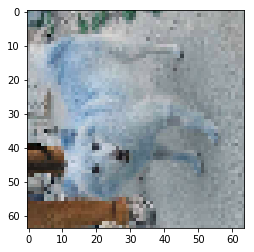

In [29]:
plt.imshow(features[1])
plt.show()

In [34]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, pooling='max')


from keras.models import Model

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

x = base_model.output
#x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])


nb_epoch = 10
batch_size = 128

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(features, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    
    return history

history = run_catdog()

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 631s 32ms/step - loss: 0.9438 - acc: 0.5320 - val_loss: 0.6705 - val_acc: 0.6390
Epoch 2/10
20000/20000 [==============================] - 602s 30ms/step - loss: 0.6808 - acc: 0.6182 - val_loss: 0.5893 - val_acc: 0.6706
Epoch 3/10
20000/20000 [==============================] - 605s 30ms/step - loss: 0.5473 - acc: 0.7224 - val_loss: 0.7467 - val_acc: 0.6122
Epoch 4/10
20000/20000 [==============================] - 603s 30ms/step - loss: 0.4070 - acc: 0.8188 - val_loss: 0.3354 - val_acc: 0.8412
Epoch 5/10
20000/20000 [==============================] - 609s 30ms/step - loss: 0.2746 - acc: 0.8883 - val_loss: 0.2090 - val_acc: 0.9176
Epoch 6/10
20000/20000 [==============================] - 612s 31ms/step - loss: 0.2126 - acc: 0.9184 - val_loss: 0.2075 - val_acc: 0.9046
Epoch 7/10
20000/20000 [==============================] - 610s 31ms/step - loss: 0.1545 - acc: 0.9411 - val_loss: 0.1

In [35]:
model.save('my_model_vgg16_08151125.h5')

In [36]:
from tqdm import tqdm

list = [0,1,2,3]

for i in tqdm(list):
    print('num:{}'.format(i))

100%|██████████| 4/4 [00:00<00:00, 13035.91it/s]

num:0
num:1
num:2
num:3


In [6]:
ROWS = 224
COLS = 224
CHANNELS = 3

TEST_DIR = './input/test/'

test_images_path =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_test_data(images_path):
    count = len(images_path)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in tqdm(enumerate(images_path)):
        image = read_image(image_file)
        data[i] = image.T
        # if i%2500 == 0: print('Processed {} of {}'.format(i, count))

    test_images = data.transpose(0,2,3,1)

    return test_images

test_images = prep_test_data(test_images_path)

12500it [02:43, 76.48it/s]


In [7]:
model = load_model('my_model_vgg16_08151125.h5')

In [9]:
predictions = model.predict(test_images,batch_size=128, verbose=1)

12500/12500 [==============================] - 195s 16ms/step


In [14]:
predictions[1]

array([0.07377321], dtype=float32)

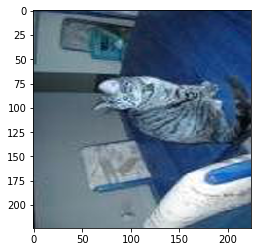

In [13]:
plt.imshow(test_images[1])
plt.show()

I am 63.53% sure this is a Dog


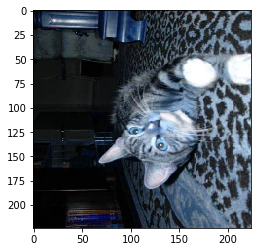

I am 92.62% sure this is a Cat


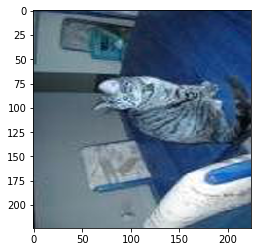

I am 100.00% sure this is a Cat


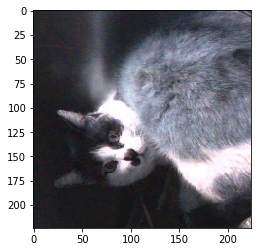

I am 100.00% sure this is a Cat


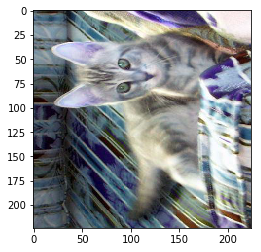

I am 70.08% sure this is a Cat


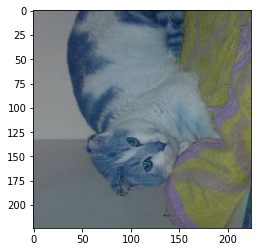

I am 83.76% sure this is a Dog


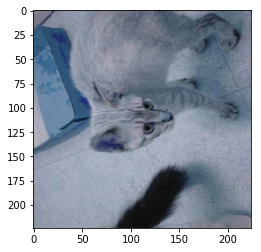

I am 89.44% sure this is a Cat


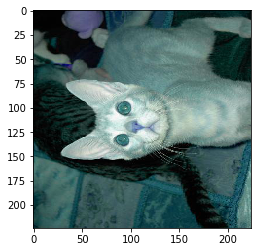

I am 90.26% sure this is a Dog


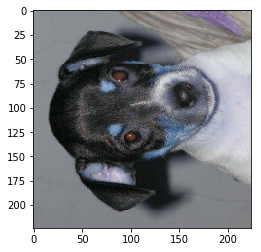

I am 68.62% sure this is a Dog


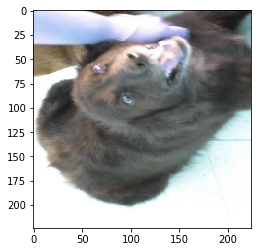

I am 70.72% sure this is a Dog


In [ ]:
for i in range(0,5):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test_images[i])
    plt.show()

In [10]:
len(predictions)

12500

In [11]:
predictions[5][0]

0.837577

In [12]:
with open('submission1.csv','w') as f:
    f.write('id,label\n')
            
with open('submission1.csv','a') as f:
    num = len(predictions)
    pred = 0
    
    for i in tqdm(range(0,num)):
        pred = predictions[i, 0]
        
        f.write('{},{}\n'.format(i+1, pred))
        
f.close()
print('file closed!')

100%|██████████| 12500/12500 [00:00<00:00, 365941.47it/s]

file closed!
